## Import statements

In [1]:
import pandas as pd
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split

In [97]:
from imblearn.over_sampling import SMOTE
import pickle

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
STOP_WORDS.add('Enron') #add the word enron
STOP_WORDS.add('enron')
STOP_WORDS.add('ENRON')


In [ ]:
!python -m spacy download en_core_web_sm

In [7]:
nlp = spacy.load("en_core_web_sm")


## Load and pre-process data

CMU has converted the Enron email dataset into a tabular representation. They've also labelled 1700 records with a category. We will be loading the dataset containing these 1700 records.

In [126]:
csv_file_path = 'data/labeled_cmu_df (1).pkl'
df = pd.read_pickle(csv_file_path)
print(df.head())

      Unnamed: 0                                     Message-ID  \
379          379   <9831685.1075855725804.JavaMail.evans@thyme>   
381          381  <21041312.1075855725847.JavaMail.evans@thyme>   
2139        2139   <5907100.1075858639941.JavaMail.evans@thyme>   
2140        2140  <26625142.1075858639964.JavaMail.evans@thyme>   
2232        2232  <19730598.1075858642129.JavaMail.evans@thyme>   

                     Date                                    From  \
379   2001-03-15 14:45:00  frozenset({'phillip.allen@enron.com'})   
381   2001-03-15 14:11:00  frozenset({'phillip.allen@enron.com'})   
2139  2001-06-20 17:04:51       frozenset({'k..allen@enron.com'})   
2140  2001-06-20 17:09:00       frozenset({'k..allen@enron.com'})   
2232  2001-08-09 12:30:58       frozenset({'k..allen@enron.com'})   

                                                     To  \
379                 frozenset({'todd.burke@enron.com'})   
381                 frozenset({'kim.bolton@enron.com'})   
2139 

We will be using only two classes from this dataset- The category containing document collaboration, and the category containing general business.

These categorizations will serve as a starting point for legal research. Collaborative emails could help create a network of interactions within the organization, as well as track communications and threads more successfully.

The breakdown of the 990 rows in the filtered dataset is as follows:



*   Document Collaboration [Target variable 1]: 135
*   General Business [Target variable 0]: 855






In [73]:
target_dict= {1: 'Document Collaboration', 0: 'General Business'}

In [128]:
#Filter CMU labelled dataset to only document collaboration and general business categories

pos_class = [1, 6]  # Doc collaboration
neg_class = [1, 1]  # General business

pos_filtered_df = df[(df['Cat_1_level_1'] == pos_class[0]) & (df['Cat_1_level_2'] == pos_class[1])].copy(deep=True)
pos_filtered_df['target'] = 1

neg_filtered_df = df[(df['Cat_1_level_1'] == neg_class[0]) & (df['Cat_1_level_2'] == neg_class[1])].copy(deep=True)
neg_filtered_df['target'] = 0

# Concat vertically
use_case_df = pd.concat([pos_filtered_df, neg_filtered_df], ignore_index=True)

#use_case_df will be the base dataset used for the following supervised learning approaches.

In [130]:
def preprocess_text(df, column):
    '''
    Function that converts all text to lower case, eliminates stop words and punctuations and returns the cleaned text
    '''

    #df[column] = df[column].astype(str).str.lower().str.replace('[^\w\s]', ' ', regex=True).str.replace('\n', ' ', regex=True)
    df[column] = df[column].astype(str).str.replace('[^\w\s]', ' ', regex=True).str.replace('\n', ' ', regex=True)


    def clean_text(text):
        doc = nlp(text)
        tokens = []
        prev_token=None
        for token in doc:
            if token.ent_type_ == 'PERSON':
              if prev_token!='person':
                tokens.append('person')
                prev_token= tokens[-1]
            elif token.text not in STOP_WORDS and not token.is_punct and not token.is_space:
                tokens.append(str(token.lemma_).lower())
                prev_token= tokens[-1]
        return ' '.join(tokens)

    df[column] = df[column].apply(clean_text)

    return df

In [76]:
#clean the 'content' column in use_case_df
preprocessed_df= preprocess_text(use_case_df, 'content')

Here's a glimpse of how the preprocessed_df looks.

In [77]:
preprocessed_df[['From', 'To', 'Date', 'Subject', 'content','target' ]].head()

,From,To,Date,Subject,content,target
0,frozenset({'michelle.cash@enron.com'}),frozenset({'felecia.acevedo@enron.com'}),2000-11-01 19:49:00,Privileged and Confidential communication to m...,person do sound right just want confirm thank ...,1
1,frozenset({'mona.petrochko@enron.com'}),"frozenset({'douglass@arterhadden.com', 'richar...",2000-09-06 13:05:00,Draft Response to CPUC OII,i take stab put draft response indicate area n...,1
2,frozenset({'steven.kean@enron.com'}),"frozenset({'sandra.mccubbin@enron.com', 'susan...",2001-05-24 07:30:00,Draft - Background and Q&A for CA residential ...,please send comment directly person 05 24 2001...,1
3,frozenset({'steven.kean@enron.com'}),frozenset({'jeff.dasovich@enron.com'}),2000-09-26 16:14:00,Re: First Cut at High Tech Messages,look good i think implicitly i think explicit ...,1
4,frozenset({'steven.kean@enron.com'}),frozenset({'jeff.dasovich@enron.com'}),2000-10-16 09:07:00,Re: DRAFT Slides for Sempra Meeting,i think presentation look good in meeting i th...,1


## Exploratory data analysis

### Distribution of data

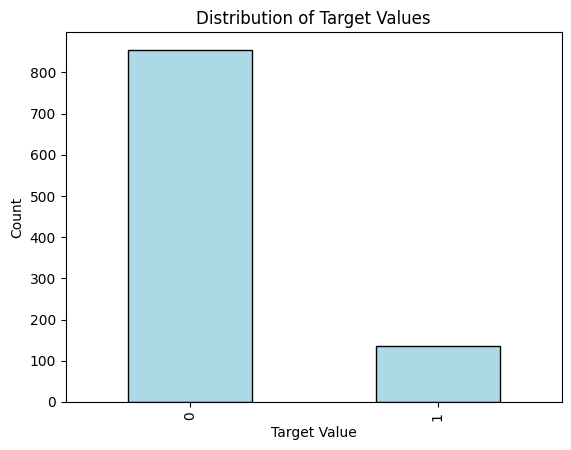

In [60]:
target_counts = preprocessed_df['target'].value_counts()
target_counts.plot(kind='bar', color='lightblue', edgecolor='black')
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of Target Values')
plt.show()

There is a clear imbalance in the dataset. This is something we will have to bear in mind and attempt to tackle along the way.

### Word cloud

We will begin by generating a word cloud to identify the most commonly used words/phrases in target 1 and target 0. This will help understand the dataset better.

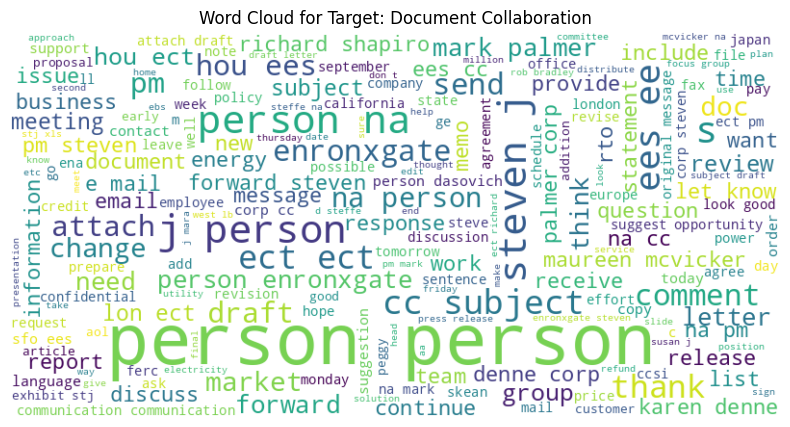

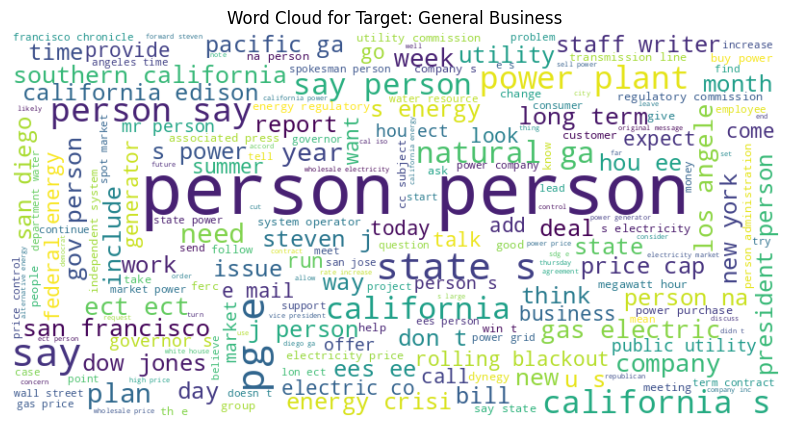

In [22]:

def generate_wordcloud(text, title=None):
    '''
    A function that generates and displays a wordcloud.
    '''
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Loop through each unique target category
for target in preprocessed_df['target'].unique():
    # Concatenate all content for the current target
    text = ' '.join(preprocessed_df[preprocessed_df['target'] == target]['content'].values)

    # Generate and display the word cloud
    title_str= "Word Cloud for Target: "+ target_dict[target]
    generate_wordcloud(text, title=title_str)


A cursory glance indicates that the General Business category has more location proper nouns and common nouns, while the document collaboration category has more verbs relating to communication (comment, attach, forward, discuss, etc.)

### Document length

We'd like to see if the document length varies significantly by target variable.

In [23]:
def plot_doc_lengths_by_category(df, text_column, target_column):
    '''
    Function to generate box plots for document lengths by category.
    '''
    data = []

    # Iterate over each category
    for category in df[target_column].unique():
        category_docs = df[df[target_column] == category][text_column]
        doc_lengths = [len(doc.split()) for doc in category_docs]

        # Extend the list with tuples of document lengths and category
        data.extend(zip(doc_lengths, [category] * len(doc_lengths)))

    # Create a DataFrame from the list
    doc_lengths_df = pd.DataFrame(data, columns=['Document Length', 'Category'])

    doc_lengths_df['Category']= doc_lengths_df['Category'].apply(lambda x: target_dict[x])

    # Plot box plots for document lengths by category
    plt.figure(figsize=(6, 6))
    sns.boxplot(x='Category', y='Document Length', data=doc_lengths_df, showfliers=False)
    plt.title('Document Lengths by Category')
    plt.xlabel('Category')
    plt.ylabel('Document Length (Words)')
    plt.xticks(rotation=45)
    plt.show()


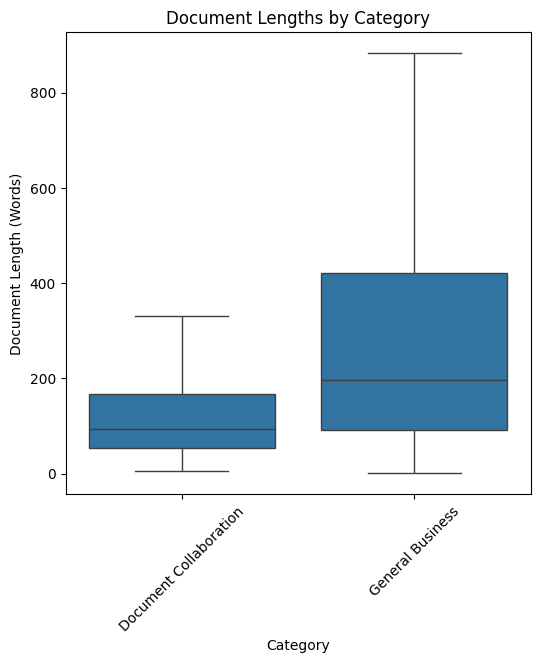

In [24]:
plot_doc_lengths_by_category(preprocessed_df, 'content', 'target')


It is clear that collaborative emails are much shorter than general business emails.

## Vectorizer

We will be generating a TF-IDF vectorizer.

(Note: As part of the exploration process, we have also tried GloVe and Spacy embeddings. Since they didn't yield significantly superior results and lowered the speed of training and inference, we chose to move ahead with TF-IDF.)

In [78]:
def create_tfidf_vectorizer(text_data):
    '''
    Function to fit a TF-IDF vectorizer on the provided text data and return the fitted vectorizer,
    '''
    vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.8)
    vectorizer.fit(text_data)
    return vectorizer

In [142]:
documents = preprocessed_df['content']
labels = preprocessed_df['target']

# Create and fit the TF-IDF vectorizer
vectorizer = create_tfidf_vectorizer(documents)

#transform content string into vector
documents2= vectorizer.transform(documents)

*documents2* will now hold our vectorized email string.

## Baseline Modeling

In [80]:
def get_metrics(classifier, documents, labels, show_confusion_matrix=False):

  '''
  Function that prints the accuracy, precision and recall for stratified 5 fold cross validation.
  '''

  all_precision=[]
  all_recall=[]
  all_accuracy= []

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # Perform 5-fold stratified K-Fold cross-validation
  for train_index, test_index in skf.split(documents, labels):
    X_train, X_test = documents[train_index], documents[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Calculate accuracy, precision and recall for this fold
    accuracy= accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append accuracy, precision and recall for averaging
    all_precision.append(precision)
    all_recall.append(recall)
    all_accuracy.append(accuracy)

    if show_confusion_matrix==True:
      # Print classification report for this fold
      print(f"Classification Report: {classification_report(y_test, y_pred)}")

  # Calculate average accuracy, precision and recall
  average_precision = np.mean(all_precision)
  average_recall = np.mean(all_recall)
  average_accuracy = np.mean(all_accuracy)

  # Print average accuracy, precision and recall
  print (classifier)
  print (f"Average Accuracy: {average_accuracy}")
  print(f"Average Precision: {average_precision}")
  print(f"Average Recall: {average_recall}")

  return classifier, average_accuracy, average_precision, average_recall



We will begin our baselining by experimenting with one or two models of each type (tree based, regression based, ensemble, probability based)

In [28]:
#Experiment with different models

models= [
    LogisticRegression(class_weight='balanced'),
    MultinomialNB(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=500),
    DecisionTreeClassifier(),
    SVC(kernel='poly', degree=5, probability=True),
    RandomForestClassifier(n_estimators=100),
    BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'), n_estimators=50, random_state=42),
    AdaBoostClassifier(base_estimator=LogisticRegression(class_weight='balanced'), n_estimators=50, random_state=42)
    ]

In [29]:
#Calculate metrics for each of the models
metrics= []

for i,model in enumerate(models):

  metrics.append(get_metrics(model, documents2, labels, show_confusion_matrix=False) )
  print ('---')


metrics_df= pd.DataFrame(metrics, columns=['model', 'accuracy', 'precision', 'recall'])


LogisticRegression(class_weight='balanced')
Average Accuracy: 0.8616161616161616
Average Precision: 0.5157033388067871
Average Recall: 0.40740740740740744
---
MultinomialNB()
Average Accuracy: 0.8636363636363636
Average Precision: 0.0
Average Recall: 0.0
---
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ran

In [30]:
metrics_df

,model,accuracy,precision,recall
0,LogisticRegression(class_weight='balanced'),0.861616,0.515703,0.407407
1,MultinomialNB(),0.863636,0.000000,0.000000
2,"XGBClassifier(base_score=None, booster=None, c...",0.878788,0.608563,0.311111
3,DecisionTreeClassifier(),0.844444,0.430359,0.370370
4,"SVC(degree=5, kernel='poly', probability=True)",0.869697,0.683333,0.088889
5,"(DecisionTreeClassifier(max_features='sqrt', r...",0.864646,0.550000,0.096296
6,"(LogisticRegression(class_weight='balanced', r...",0.863636,0.523452,0.259259
7,"(LogisticRegression(class_weight='balanced', r...",0.804040,0.369276,0.614815
8,DecisionTreeClassifier(),0.842424,0.412239,0.333333


Observations:


*   Of the classifiers evaluated, it is clear that Logistic Regression, XGBoost and AdaBoost show most promise with respect to the precision and recall metrics, specifically. It is clear that the accuracy metric is misleading and we will not be using it hereafter for finetuning.
* Since it is important to ensure that we categorize all category 1 (collaboration) emails correctly, we're alright with compromising on precision if it means a higher recall.
*   Given the slow speed of training XGBoost and AdaBoost classifiers, we will be experimenting with LogisticRegression and DecisionTree Classifiers since the results close enough to the Boosting trees classifiers.
* Therefore, we've chosen to prioritize simplicity and speed, if the trade-off is minimal.

In [31]:
#Only use LR and Decision Tree Classifier for further finetuning.

models2= [
    LogisticRegression(class_weight='balanced'),
    DecisionTreeClassifier()]

## SMOTE

Category 1 is consistently performing poorly as compared to Category 2, and this could primarily be due to the class imbalance in the dataset.

To combat this, let us create artificial data using SMOTE, and experiment with a baseline Logistic Regression model.

In [32]:
skf = StratifiedKFold(n_splits=5)

def get_metrics2(model, X, y, sampling_strategy_float= 0.2 ):

  iteration_data = []

  #If variance is greater than 0.3 or sampling is less than 0.9, keep running the loop below
  while (sampling_strategy_float<0.9):

    accuracies = []

    for train_index, test_index in skf.split(X, y):

      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      smote = SMOTE(sampling_strategy= sampling_strategy_float)
      X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
      model.fit(X_train_res, y_train_res)
      y_pred = model.predict(X_test)

      #Compute and append recall score
      accuracies.append(recall_score(y_test, y_pred))


    maximum= np.max(accuracies)
    minimum= np.min(accuracies)
    mean= np.mean(accuracies)
    #append the max, min and mean to iteration data to plot
    iteration_data.append([mean, maximum, minimum, sampling_strategy_float])

    #add 50% more to the sampling strategy
    sampling_strategy_float*= 1.5

  # Return metrics
  return pd.DataFrame(iteration_data, columns=['mean', 'max', 'min', 'sampling strategy'])

In [33]:
iteration_data= get_metrics2(LogisticRegression(class_weight='balanced'), documents2, labels)

In [34]:
iteration_data

,mean,max,min,sampling strategy
0,0.355556,0.518519,0.222222,0.200
1,0.340741,0.518519,0.148148,0.300
2,0.318519,0.518519,0.222222,0.450
3,0.311111,0.518519,0.222222,0.675


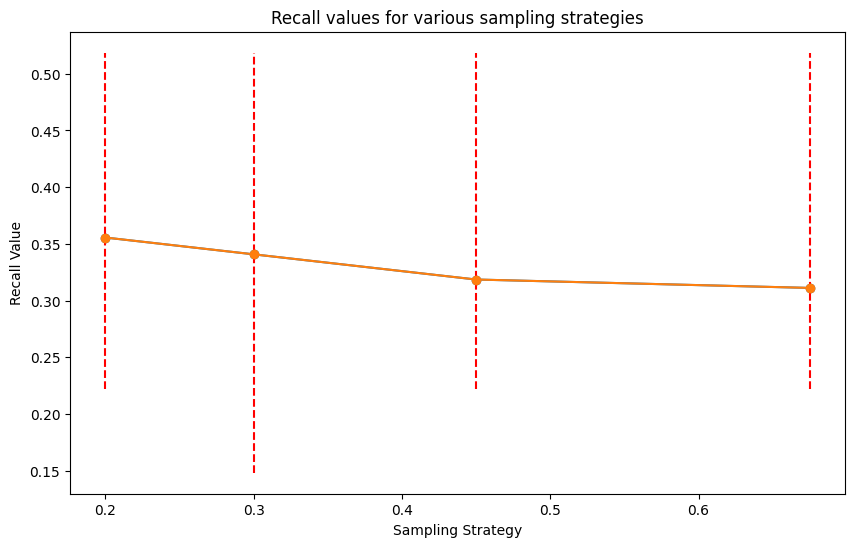

In [35]:
def plot_data(iteration_data):
  """
  Plots the mean with a dot, max and min with vertical lines, and joins the dots.

  Args:
      iteration_data (list): A list of dictionaries containing 'mean', 'max', and 'min' keys.
  """
  # Extract data from list
  means = iteration_data['mean'].values.tolist()
  max_values = iteration_data['max'].values.tolist()
  min_values = iteration_data['min'].values.tolist()
  sampling_strategies= iteration_data['sampling strategy'].values.tolist()

  # Create the plot
  plt.figure(figsize=(10, 6))

  # Plot means with dots
  plt.plot(sampling_strategies, means, marker='o', label='Mean')

  # Plot max and min lines
  plt.vlines(sampling_strategies, min_values, max_values, colors='red', linestyles='dashed', label='Max-Min Range')

  # Join dots with a line
  plt.plot(sampling_strategies, means, marker='o', linestyle='-', label='Mean')

  # Set labels and title
  plt.xlabel("Sampling Strategy")
  plt.ylabel("Recall Value")
  plt.title("Recall values for various sampling strategies")

  plt.show()

plot_data(iteration_data)

Observations:


*   Recall is in fact, decreasing using the SMOTE method.
*   Perhaps the synthetic samples aren't emulating the semantic representation of the textual data.
* We will not be going ahead with this method.



## Using Word Length as a Feature

We had observed in our EDA that word length varies significantly between target 0 and 1. We can try using the additional feature to raise the precision and recall.

In [81]:
#Leverage word length as a feature

preprocessed_df['word_length'] = preprocessed_df['content'].apply(lambda x: len(x.split()))
word_lengths = preprocessed_df['word_length'].values.reshape(-1, 1)  # Reshape for concatenation
# Combine the TFIDF vectors with the word length feature
documents3 = hstack((documents2, word_lengths))
documents3= documents3.tocsr()

*documents3* variable now contains the concatenated vector containing the tf idf vector as well as the word length feature.

In [37]:
#Calculate metrics for each of the models
metrics= []

for i,model in enumerate(models2):

  metrics.append(get_metrics(model, documents3, labels, show_confusion_matrix=True) )
  print ('---')

metrics_df2= pd.DataFrame(metrics, columns=['model', 'accuracy', 'precision', 'recall'])


Classification Report:               precision    recall  f1-score   support

           0       0.91      0.95      0.93       171
           1       0.56      0.37      0.44        27

    accuracy                           0.87       198
   macro avg       0.73      0.66      0.69       198
weighted avg       0.86      0.87      0.86       198

Classification Report:               precision    recall  f1-score   support

           0       0.93      0.82      0.87       171
           1       0.34      0.59      0.43        27

    accuracy                           0.79       198
   macro avg       0.63      0.71      0.65       198
weighted avg       0.85      0.79      0.81       198

Classification Report:               precision    recall  f1-score   support

           0       0.88      0.68      0.77       171
           1       0.17      0.41      0.24        27

    accuracy                           0.64       198
   macro avg       0.52      0.54      0.50       198
weigh

In [38]:
metrics_df2

,model,accuracy,precision,recall
0,LogisticRegression(class_weight='balanced'),0.790909,0.403006,0.518519
1,DecisionTreeClassifier(),0.836364,0.416304,0.348148


There is some improvement in the precision, recall and accuracy values after adding 'length' as a feature. Now let us perform Grid Search to find the optimal hyperparameter values for the two classifiers.

## Grid Search Optimization

In [83]:
X_train, X_test, y_train, y_test = train_test_split(documents3, labels, test_size=0.2, random_state=42)

### For Logistic Regression

In [56]:
lr_model = LogisticRegression()

#Combinations of parameters
param_grid = {
    'class_weight': [ 'balanced' , {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.6, 1:0.4}, {0:0.2, 1:0.8} ]

                     , 'solver': [ 'liblinear' ,'newton-cg', 'lbfgs']

                      ,'penalty':['l1', 'l2', 'elasticnet']

                      , 'max_iter': [100, 30, 10, 150]

          }


# Create GridSearchCV object
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)

#Best hyperparameters
best_params = grid_search.best_params_

#Best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print (f"Best Model: {best_model}")
print(f"Best Hyperparameters: {best_params}")
print(f"Test Set Precision: {precision}")
print(f"Test Set Recall: {recall}")

Best Model: LogisticRegression(class_weight='balanced')
Best Hyperparameters: {'class_weight': 'balanced'}
Test Set Precision: 0.42105263157894735
Test Set Recall: 0.6666666666666666


### For Decision Tree Classifier

In [59]:
dt_model = DecisionTreeClassifier()

#Combinations of parameters
param_grid = {
    'criterion': ['gini', 'logloss', 'entropy' ],
    'min_samples_split': [None,5, 7],
    'max_features': [100, 300, 500, None] ,
   'class_weight': ['balanced', {0:0.3, 1:0.7}, {0:0.2, 1:0.8} ]
}


# Create GridSearchCV object
grid_search2 = GridSearchCV(estimator=dt_model, param_grid=param_grid, scoring='recall', cv=5)
grid_search2.fit(X_train, y_train)

#Best hyperparameters
best_params = grid_search2.best_params_

#Best model
best_model = grid_search2.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print (f"Best Model: {best_model}")
print(f"Best Hyperparameters: {best_params}")
print(f"Test Set Precision: {precision}")
print(f"Test Set Recall: {recall}")

Best Model: DecisionTreeClassifier(class_weight='balanced', min_samples_split=7)
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': None, 'min_samples_split': 7}
Test Set Precision: 0.34285714285714286
Test Set Recall: 0.5


Observations:

*  We used recall as the scoring criterion because for this use case, recognizing all label 1 emails is more important than getting all label 1 email prediction right.
* Logistic Regression performs better than Decision Tree. That will be the model we will focus on hereafter.
*   Let us look at the accuracy, precision and recall for the best LR model using stratified 5 fold.



### K fold validation using best model

In [84]:
#Calculate metrics for the best model from above.

best_model= LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear') #from grid search above
metrics= []

metrics.append(get_metrics(best_model, documents3, labels, show_confusion_matrix=True) )

metrics_df3= pd.DataFrame(metrics, columns=['model', 'accuracy', 'precision', 'recall'])



Classification Report:               precision    recall  f1-score   support

           0       0.92      0.80      0.86       171
           1       0.31      0.56      0.39        27

    accuracy                           0.77       198
   macro avg       0.61      0.68      0.63       198
weighted avg       0.84      0.77      0.79       198

Classification Report:               precision    recall  f1-score   support

           0       0.94      0.77      0.85       171
           1       0.32      0.67      0.43        27

    accuracy                           0.76       198
   macro avg       0.63      0.72      0.64       198
weighted avg       0.85      0.76      0.79       198

Classification Report:               precision    recall  f1-score   support

           0       0.96      0.71      0.82       171
           1       0.31      0.81      0.45        27

    accuracy                           0.73       198
   macro avg       0.64      0.76      0.63       198
weigh

In [85]:
metrics_df3

,model,accuracy,precision,recall
0,"LogisticRegression(class_weight='balanced', pe...",0.744444,0.310916,0.711111


## Sensitivity Analysis of Best Model Fit

Now that we've finalized the model we're going ahead with, we will be performing a sensitivity analysis on the hyperparameters that most influence the model.

Our initial experiments indicate that the biggest changes in precision come from the class weights hyperparameter.

We'll examine the effect by varying one parameter and keeping the remainder constant. We'll use Recall as our scoring value.

In [59]:
lr_model= LogisticRegression(penalty='l1', solver='liblinear')

#Trying out different class weights
param_grid = {
    'class_weight': [ 'balanced' , {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.6, 1:0.4}, {0:0.2, 1:0.8} ]
          }


# Create GridSearchCV object
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)

sensitivity_analysis=pd.DataFrame(grid_search.cv_results_)

print (sensitivity_analysis[['param_class_weight',  'mean_test_score']])

  param_class_weight  mean_test_score
0           balanced         0.712253
1   {0: 0.3, 1: 0.7}         0.036364
2   {0: 0.4, 1: 0.6}         0.000000
3   {0: 0.6, 1: 0.4}         0.000000
4   {0: 0.2, 1: 0.8}         0.404743


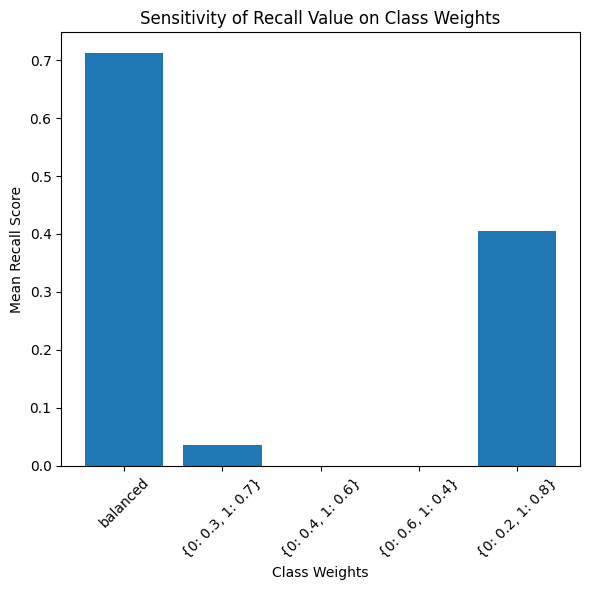

In [66]:
#Plot the sensitivity of the recall value on the class weights

plt.figure(figsize=(6, 6))
class_weights = sensitivity_analysis['param_class_weight'].apply(str)
mean_test_scores = sensitivity_analysis['mean_test_score']

plt.bar(class_weights, mean_test_scores)
plt.title('Sensitivity of Recall Value on Class Weights')
plt.xlabel('Class Weights')
plt.ylabel('Mean Recall Score')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Feature Importance

In [87]:
# Extract feature importance
feature_importance = best_model.coef_[0]

# Map features to words
feature_names = list(vectorizer.get_feature_names_out()) + ['word_length']
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index()


print (feature_importance_df.head(10))

    index         feature  importance
0   81767           draft   15.592324
1   49868          change   11.998425
2   48496      cc subject    6.869015
3   48535            ccsi    3.141932
4  151700            memo    2.255940
5  187376    presentation    2.228947
6   54401             com    2.182846
7   90420      enronxgate    2.111600
8   55536         comment    2.104821
9   57071  communications    1.840052


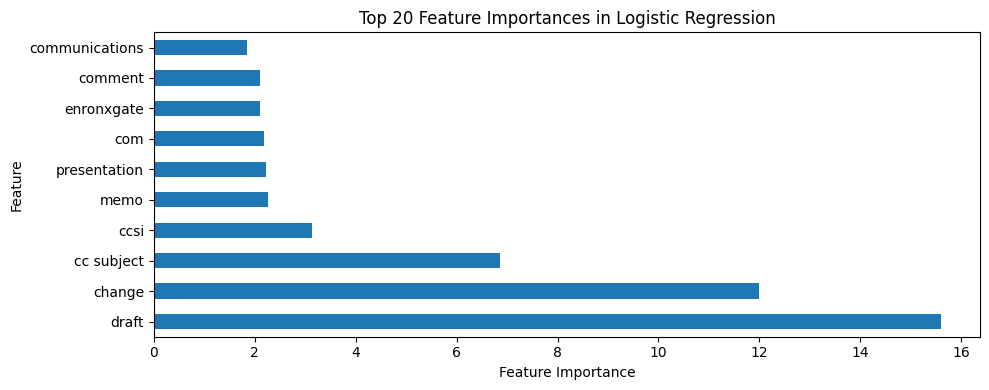

In [91]:
top_features = feature_importance_df.head(10)

top_features.set_index('feature', inplace=True)
top_features.plot(kind='barh', y='importance', figsize=(10,4), legend=False)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances in Logistic Regression')
plt.tight_layout()
plt.show()

## Oversampling using nlpaug library

In order to improve our overall precision and recall values, we will be experimenting with a new library.

The nlpaug library is specifically designed for augmentation of textual data. Let us see how far that takes us.

In [18]:
!pip install requests nlpaug


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.9 MB/s eta 0:00:00


In [19]:
import nlpaug.augmenter.word as naw


In [20]:
aug = naw.SynonymAug(aug_p=0.3, aug_min=1, aug_max=10)
'''
aug_p: percentage of words to be augmented
aug_min and aug_max:  Min and max no. of words to be augmented.

The documentation mentions:
If calculated result from aug_p is smaller than aug_max, will use calculated result from aug_p.
Otherwise, using aug_max.
'''

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


By default, SynonymAug uses the WordNet vectorizer by NLTK.

We will be performing minority oversampling.

For every 1 sentence belonging to target 1, let us augment 3 sentences.

In [39]:
def augment_text(text, augmenter, num_augmentations=3):
    '''
    Function to provide two augmented sentences for the provided text.
    '''
    augmented_texts = [augmenter.augment(text) for _ in range(num_augmentations)]
    return augmented_texts

In [40]:
augmented_data = []

for index, row in preprocessed_df.iterrows():
    if row['target'] == 1:
        original_text = row['content']
        augmented_texts = augment_text(original_text, aug)
        for aug_text in augmented_texts:
            augmented_data.append({'content': aug_text[0], 'target': 1})

augmented_df = pd.DataFrame(augmented_data)

# Combine original and augmented data
preprocessed_df2 = pd.concat([preprocessed_df, augmented_df], ignore_index=True)


In [41]:
preprocessed_df2[['From', 'To', 'Date', 'Subject', 'content','target' ]].head()

,From,To,Date,Subject,content,target
0,frozenset({'michelle.cash@enron.com'}),frozenset({'felecia.acevedo@enron.com'}),2000-11-01 19:49:00,Privileged and Confidential communication to m...,person do sound right just want confirm thank ...,1
1,frozenset({'mona.petrochko@enron.com'}),"frozenset({'douglass@arterhadden.com', 'richar...",2000-09-06 13:05:00,Draft Response to CPUC OII,i take stab put draft response indicate area n...,1
2,frozenset({'steven.kean@enron.com'}),"frozenset({'sandra.mccubbin@enron.com', 'susan...",2001-05-24 07:30:00,Draft - Background and Q&A for CA residential ...,please send comment directly person 05 24 2001...,1
3,frozenset({'steven.kean@enron.com'}),frozenset({'jeff.dasovich@enron.com'}),2000-09-26 16:14:00,Re: First Cut at High Tech Messages,look good i think implicitly i think explicit ...,1
4,frozenset({'steven.kean@enron.com'}),frozenset({'jeff.dasovich@enron.com'}),2000-10-16 09:07:00,Re: DRAFT Slides for Sempra Meeting,i think presentation look good in meeting i th...,1


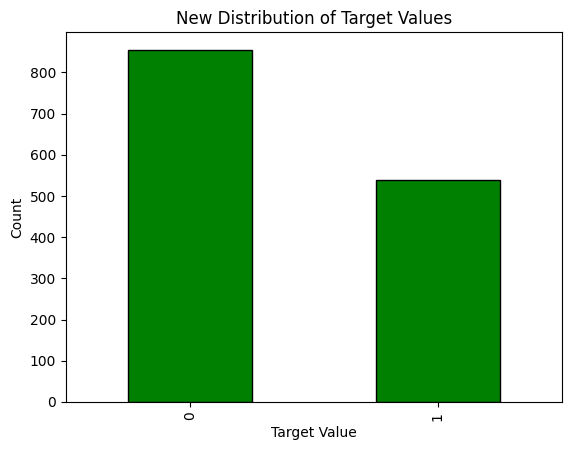

In [43]:
target_counts = preprocessed_df2['target'].value_counts()
target_counts.plot(kind='bar', color='green', edgecolor='black')
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('New Distribution of Target Values')
plt.show()

In [42]:
target_counts

target
0    855
1    405
Name: count, dtype: int64

Now that the ratio of target 0 to target 1 has improved, we will vectorize and run the best model on the augmented data.

In [44]:
documents_augmented = preprocessed_df2['content']
labels_augmented = preprocessed_df2['target']

# Create and fit the TF-IDF vectorizer
vectorizer_augmented = create_tfidf_vectorizer(documents_augmented)

#transform content string into vector
documents_augmented2= vectorizer.transform(documents_augmented)

In [45]:
preprocessed_df2['word_length'] = preprocessed_df2['content'].apply(lambda x: len(x.split()))
word_lengths_augmented = preprocessed_df2['word_length'].values.reshape(-1, 1)  # Reshape for concatenation
# Combine the TFIDF vectors with the word length feature
documents_augmented3 = hstack((documents_augmented2, word_lengths_augmented))
documents_augmented3= documents_augmented3.tocsr()

In [46]:
best_model= LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear') #from grid search above
metrics= []

metrics.append(get_metrics(best_model, documents_augmented3, labels_augmented, show_confusion_matrix=True) )

metrics_df4= pd.DataFrame(metrics, columns=['model', 'accuracy', 'precision', 'recall'])

Classification Report:               precision    recall  f1-score   support

           0       0.81      0.75      0.78       171
           1       0.65      0.72      0.68       108

    accuracy                           0.74       279
   macro avg       0.73      0.74      0.73       279
weighted avg       0.75      0.74      0.74       279

Classification Report:               precision    recall  f1-score   support

           0       0.81      0.77      0.79       171
           1       0.67      0.72      0.69       108

    accuracy                           0.75       279
   macro avg       0.74      0.75      0.74       279
weighted avg       0.76      0.75      0.75       279

Classification Report:               precision    recall  f1-score   support

           0       0.87      0.86      0.86       171
           1       0.78      0.80      0.79       108

    accuracy                           0.84       279
   macro avg       0.83      0.83      0.83       279
weigh

In [48]:
metrics_df4

,model,accuracy,precision,recall
0,"LogisticRegression(class_weight='balanced', pe...",0.769176,0.686901,0.746296


Using the nlpaug library has significantly increased the precision. Both are now more balanced.

## Creating a final model

We will now be putting all the pieces together, creating and training the final model and saving it.

In [133]:
#Split into train and test

df = use_case_df[['From', 'To', 'Date', 'Subject', 'content', 'target']]
X = df['content']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.DataFrame({'content': X_train, 'target': y_train})

#Perform preprocessing on the training data

train_df= preprocess_text(train_df, 'content')

#Augment text

augmented_data = []

for index, row in train_df.iterrows():
    if row['target'] == 1:
        original_text = row['content']
        augmented_texts = augment_text(original_text, aug)
        for aug_text in augmented_texts:
            augmented_data.append({'content': aug_text[0], 'target': 1})

augmented_df = pd.DataFrame(augmented_data)

augmented_train_df = pd.concat([train_df, augmented_df], ignore_index=True)

X_train_augmented = augmented_train_df['content']
y_train_augmented = augmented_train_df['target']


#Create a vectorizer
vectorizer_augmented = create_tfidf_vectorizer(X_train_augmented)
X_train_augmented_vectorized = vectorizer_augmented.transform(X_train_augmented)

#Add word length as a feature

def calculate_word_lengths(text_data):
    '''
    Function to calculate word lengths
    '''
    return text_data.apply(lambda x: len(x.split())).values.reshape(-1, 1)

word_lengths_augmented_train = calculate_word_lengths(X_train_augmented)
X_train_augmented_combined = hstack((X_train_augmented_vectorized, word_lengths_augmented_train)).tocsr()

#Create a model
best_model= LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

#Train the model
best_model.fit(X_train_augmented_combined, y_train_augmented)

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

## Saving the vectorizer and final model

In [134]:
# Save TF-IDF vectorizer
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer_augmented, f)

# Save Logistic Regression model
with open('models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Now let us build a pipeline that will accept test data and predict the output.

## Building the prediction pipeline

### Pipeline Function

In [135]:
def preprocess_and_predict(x_data, vectorizer, model):
    '''
    Function to preprocess text data, vectorize it using a TF-IDF vectorizer, add word length as a feature,
    stack it with the TF-IDF vectors, and make predictions using the provided model.

    Parameters:
    - y_data: pandas Series containing text data.
    - vectorizer: fitted TF-IDF vectorizer.
    - model: trained LR model.

    Returns:
    - predictions: List of predicted labels.
    '''
    # Preprocess test data
    x_data2= pd.DataFrame({'content': x_data})
    x_data2= preprocess_text(x_data2, 'content')
    x_data= x_data2['content']

    # Vectorize
    X_data_vectorized = vectorizer.transform(x_data)

    # Calculate word lengths
    word_lengths = calculate_word_lengths(x_data)

    # Stack TF-IDF vectors and word lengths
    X_data_combined = hstack((X_data_vectorized, word_lengths)).tocsr()

    # Predict using the model
    predictions = model.predict(X_data_combined)

    return predictions


### Load saved models for use

In [136]:
#Load TF-IDF vectorizer
with open( 'models/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer_augmented_final = pickle.load(f)

#Load Logistic Regression model
with open('models/logistic_regression_model.pkl', 'rb') as f:
    best_model_final = pickle.load(f)

### Predict using function

In [137]:
#Predict on X_test

predictions_test = preprocess_and_predict(X_test, vectorizer_augmented_final, best_model_final)

precision = precision_score(y_test, predictions_test)
recall = recall_score(y_test, predictions_test)
accuracy= accuracy_score(y_test, predictions_test)
report = classification_report(y_test, predictions_test)

print (f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("\nClassification Report:")
print(report)

Accuracy: 0.7323232323232324
Precision: 0.26229508196721313
Recall: 0.6666666666666666

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       174
           1       0.26      0.67      0.38        24

    accuracy                           0.73       198
   macro avg       0.60      0.70      0.60       198
weighted avg       0.86      0.73      0.77       198



In [140]:
data = list(zip(list(use_case_df['content']), list(X_test), list(y_test), list(predictions_test)))

analysis_df= pd.DataFrame(data, columns= ['Email','Cleaned Email', 'Actual', 'Predicted'])
analysis_df.to_csv('analysis.csv')

## Conclusion

### What didn't work?



- Using SMOTE and KMeans SMOTE for minority oversampling and general undersampling, both, didn't yield good results.
- We intentionally refrained from using the sender and receiver details as a feature in order to generalize the model.
- We also used an LSTM model. However it is our guess that the small number of examples is the reason this model didn't perform significantly better.
- We also used GloVe and Spacy's NLP embeddings instead of TF-IDF.

### What were the primary sources of error?

On a closer look of all the misclassified data, following seemed to be the major reasons for error:
- The model relies on the length of the email greatly. A shorter email of Class 0 throws off the model.
- There are some words like 'discuss', 'draft', 'schedule', 'meet', 'prepare', 'advice', 'confirm' that are very commonly used in Class 1 examples. The presence of multiple such instances misclassifies General emails into collaboration emails (Class 0 is classified as Class 1).

### What can be done to improve the performance?



- We would've liked to manually label some additional training examples to expand the training dataset size.
- We would've liked to experiment with newer vectorizers such as the GPT-2 or GPT-3 vectorizer.
- Another interesting path would've been to feed GPT-3 our training examples and ask it to create synthetic samples based on it.
- With additional computation resources, we might have explored XGBoost some more as it showed some promise initially.

### Summary

- We began with the original dataset, which had 135 Collaboration emails and 835 General emails.
-For our pre-processing step, we replaced all identified Name Proper Nouns with the word 'Person'. We also considered 'Enron' as a stop word, eliminated all stop words and converted the text to lower case.
- We then baselined some tree based, probability based, instance based and ensemble models. Considering the overall scores and prioritizing speed over accuracy, we chose to go ahead with the Logistic Regression and Decision Tree models.
- Exploration had uncovered that the collaborative emails had fewer verbs than the general emails. However, this could also be due to the length of the collaborative emails being smaller. There was a good improvement in the overall metrics when 'word_length' as a feature was added. This word length was used as a proxy for 'number of verbs' as a feature.
- We chose the best hyperparameters using grid search CV, and finalized on Logistic Regression as the model of our choice. This was for numerous reasons: better performance, faster training and inference times and better explainability.
- While SMOTE didn't yield good results, using the nlpaug library improved the recall significantly. The library uses synonyms (using WordNet), and we used it to perform minority oversampling on target variable 1. We decided that for every 1 training example of the minority class, we will be adding 3 more training examples.
- We ended with a 20% increase in our final recall.
